### DEIT-III Pre-trained Artifacts

In [1]:
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt



In [2]:
from models_v2 import *

In [3]:
tiny = deit_tiny_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True)
small = deit_small_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True)
#base = deit_base_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True) 
#large = deit_large_patch16_LS(pretrained=True, img_size=384, pretrained_21k = True)

In [4]:
def show_artifacts(test_model, test_image, log_scale = False, token = 0):
    """
    Generate the Attention maps and the norm values for the DEIT-III model

    test_model: DEIT-III model to be tested,
    test_image:  Image of the correct size for the corresponding model, and batch dimension is accounted for

    """

    test_model(test_image)

    ## Norm of feature values after MLP
    output = test_model.block_output['block11']
    output = output.squeeze(0)
    output = output[1:]
    #output.shape
    # copmute norm of all output elements
    output_norms = output.norm(dim=-1)
    #output_norms.shape
    
    plt.imshow(output_norms.reshape(24, 24).detach().numpy())
    plt.axis('off')  # Turn off axis labels
    plt.colorbar(label='Norm Values')  # Add a colorbar as a legend
    plt.show()

    plt.hist(output_norms.detach().numpy(), bins=50)
    plt.xlabel('Norm Values')
    plt.ylabel('Frequency')
    plt.show()

    ## Attention maps for the last Attention Head

    
    attn_map_mean = test_model.blocks[len(test_model.blocks)-1].attn.attn_map.squeeze(0).mean(dim=0)
    attn_map_mean = attn_map_mean[token][1:]
    if log_scale:
        attn_map_mean = torch.log(attn_map_mean + 1e-6)
    #attn_map_mean.shape

    plt.imshow(attn_map_mean.reshape(24, 24).detach().numpy())
    plt.axis('off') 
    plt.colorbar(label='CLS attention map')  
    plt.show()



    ## All attention maps
    num_images = len(test_model.blocks)
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_images):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        attn_map = attn_map[token][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis('off')
        axes[i].set_title(f'Block {i+1}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    


In [5]:
def show_all_tokens(test_model):
    # # Attention maps, last layer, all tokens
    num_tokens = 24 * 24
    num_cols = 6
    num_rows = (num_tokens + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_tokens):
        attn_map = test_model.blocks[len(test_model.blocks)-1].attn.attn_map.squeeze(0).mean(dim=0)
        attn_map = attn_map[i][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis('off')
        axes[i].set_title(f'Token {i+1}')


In [6]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Assume `image_tensor` is a tensor of shape (3, H, W), e.g., (3, 32, 32)
def plot_image(image_tensor):
    # Undo normalization if needed (optional step)

    # Convert tensor to NumPy format
    image_np = image_tensor.permute(1, 2, 0).numpy()  # Rearrange to (H, W, C)

    # Clip values to the valid range [0, 1]
    image_np = image_np.clip(0, 1)

    # Plot the image
    plt.imshow(image_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example: Plot a single image from CIFAR-100
import torchvision



### Nice stuff

In [7]:
chosen_one = small
chosen_one

vit_models(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Layer_scale_init_Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,

In [8]:
image = 'racket.JPEG'

In [9]:
from PIL import Image
import numpy as np
import torch

def get_image(image):
    # Open the image
    img = Image.open('./images/' + image).convert('RGB')

    # Resize the image to 384x384
    img = img.resize((384, 384))

    # Convert the image to a NumPy array and transpose the dimensions
    img = np.array(img).transpose(2, 0, 1)

    # Convert the NumPy array to a PyTorch tensor and normalize the values
    img = torch.tensor(img).float() / 255.0

    # Add a batch dimension
    img = img.unsqueeze(0)

    return img

img = get_image(image)



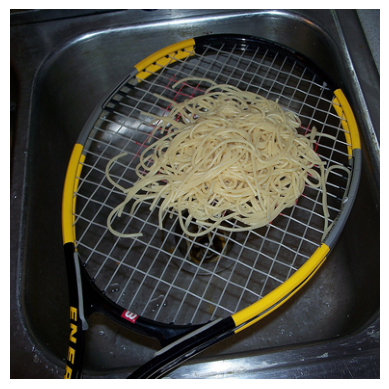

In [10]:
plot_image(img.squeeze(0))

In [11]:
chosen_one(img).shape

torch.Size([1, 1000])

### Alisia stuff (bad)

In [12]:
combined_attention = chosen_one.blocks[11].attn.attn_map.squeeze(0).mean(dim=0)[1:, 1:].detach().numpy()
combined_attention.shape

(576, 576)

In [13]:
chosen_one.block_output['block11'].shape

torch.Size([1, 577, 384])

In [14]:
local_feature_norms = chosen_one.block_output['block11'].squeeze(0).norm(dim=-1)[1:].reshape(24, 24).detach().numpy()
local_feature_norms.shape


(24, 24)

Mean norm for high-attention patches: 827.8550415039062


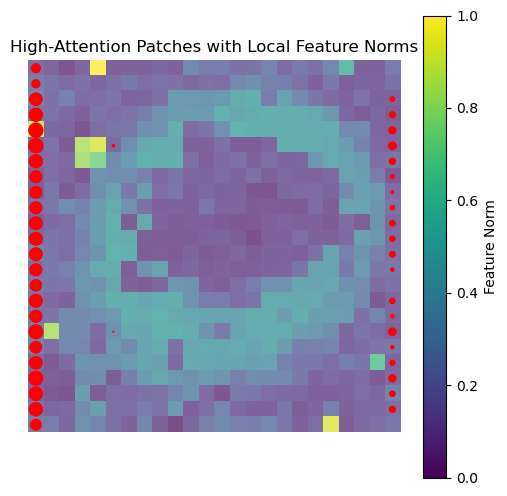

In [15]:
import numpy as np

high_attention_threshold = np.percentile(combined_attention, 99.9)
high_attention_indices = np.where(combined_attention >= high_attention_threshold)

scale_factor = 24
scaled_attention_indices = (high_attention_indices[0] // scale_factor, high_attention_indices[1] // scale_factor)

attention_values = combined_attention[high_attention_indices]

high_attention_norms = local_feature_norms[scaled_attention_indices]

mean_high_attention_norm = np.mean(high_attention_norms)
print(f"Mean norm for high-attention patches: {mean_high_attention_norm}")

dot_sizes = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values)) * 100

plt.figure(figsize=(6, 6))
plt.imshow(local_feature_norms, cmap="viridis", alpha=0.7)
plt.scatter(scaled_attention_indices[1], scaled_attention_indices[0], color="red", s=dot_sizes)
plt.title("High-Attention Patches with Local Feature Norms")
plt.axis("off")
plt.colorbar(label="Feature Norm")
plt.show()


### Back to the good part

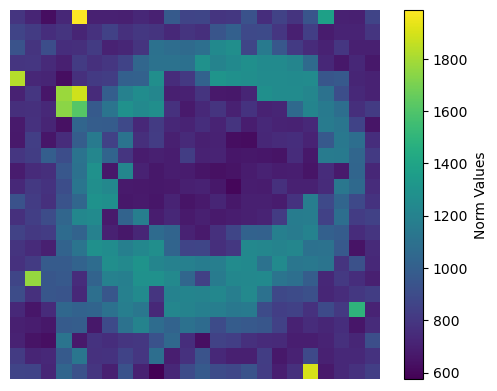

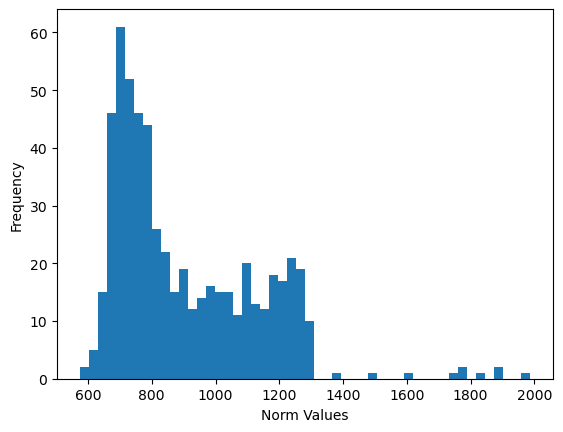

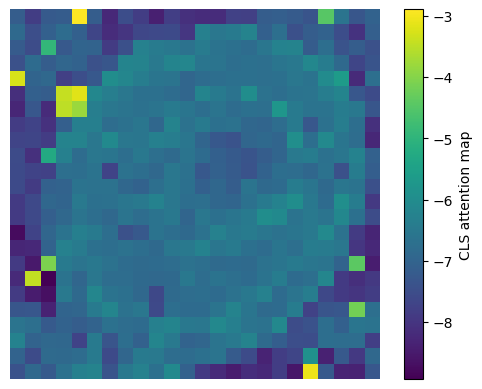

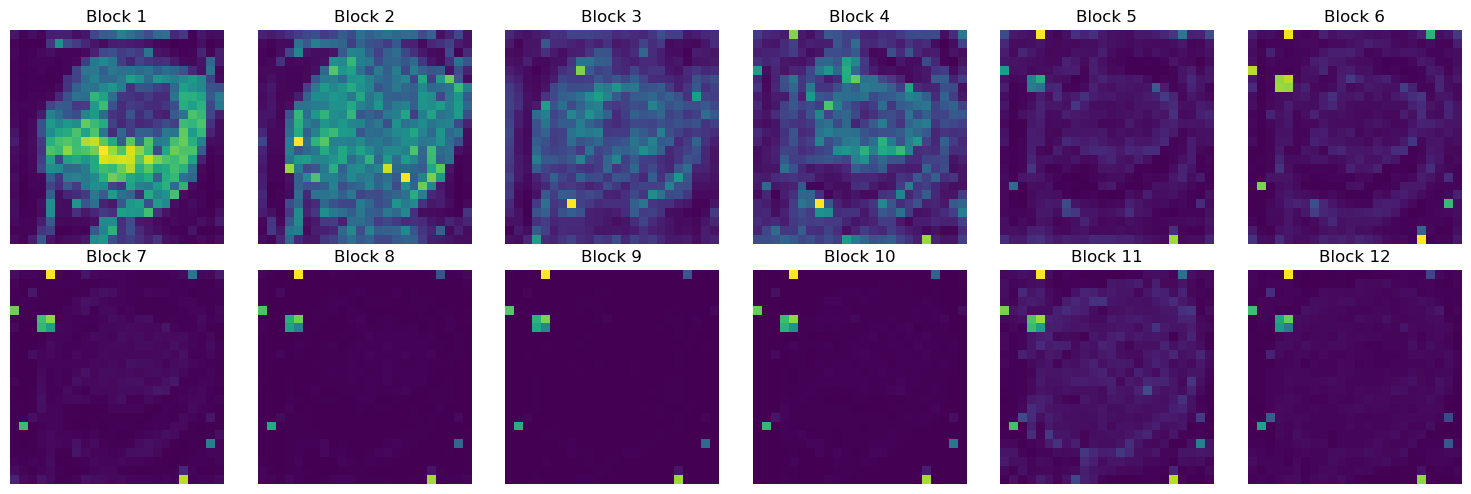

In [16]:
show_artifacts(test_model=chosen_one, test_image=img, log_scale=True, token = 0)

In [17]:
def top_norm_tokens(test_model):
    output = test_model.block_output['block11']
    output = output.squeeze(0)
    output = output[1:]
    output_norms = output.norm(dim=-1)
    top_tokens = torch.argsort(output_norms, descending=True)
    return top_tokens


In [18]:
def top_attn_tokens(test_model):
    attn_map_mean = test_model.blocks[len(test_model.blocks)-1].attn.attn_map.squeeze(0).mean(dim=0)
    top_tokens = torch.argsort(attn_map_mean[0][1:], descending=True)
    return top_tokens

In [19]:
top_norm = top_norm_tokens(chosen_one)[:20]
top_attn = top_attn_tokens(chosen_one)[:20]
intersection = np.intersect1d(top_attn, top_norm)

In [20]:
intersection

array([  4,  20,  96, 123, 124, 147, 148, 409, 478, 571])

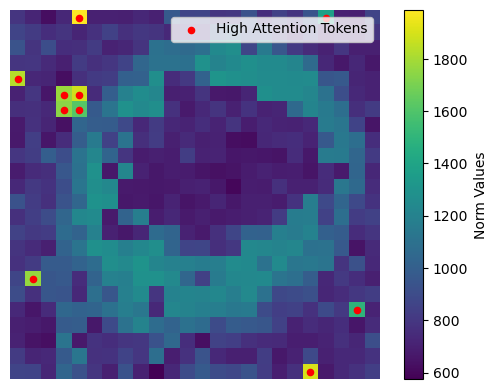

In [21]:
## Norm of feature values after MLP
output = chosen_one.block_output['block11']
output = output.squeeze(0)
output = output[1:]
# compute norm of all output elements
output_norms = output.norm(dim=-1)

plt.imshow(output_norms.reshape(24, 24).detach().numpy())
plt.axis('off')  # Turn off axis labels
plt.colorbar(label='Norm Values')  # Add a colorbar as a legend

# Place red dots at the pixels present in the "intersection" vector
intersection_indices = np.unravel_index(intersection, (24, 24))
plt.scatter(intersection_indices[1], intersection_indices[0], color='red', s=20, label='High Attention Tokens')  # Adjusted dot size

# Add a legend
plt.legend(loc='upper right')

plt.show()

### check selected tokens

In [22]:
def show_progression(test_model, token = 'cls'):
    ## All attention maps
    num_images = len(test_model.blocks)
    num_cols = 6
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 2.5))
    axes = axes.flatten()

    for i in range(num_images):
        attn_map = test_model.blocks[i].attn.attn_map.squeeze(0).mean(dim=0)
        if token == 'cls':
            attn_map = attn_map[0][1:]
        else:
            attn_map = attn_map[token + 1][1:]
        attn_map_img = attn_map.reshape(24, 24).detach().numpy()

        axes[i].imshow(attn_map_img)
        axes[i].axis('off')
        axes[i].set_title(f'Block {i+1}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

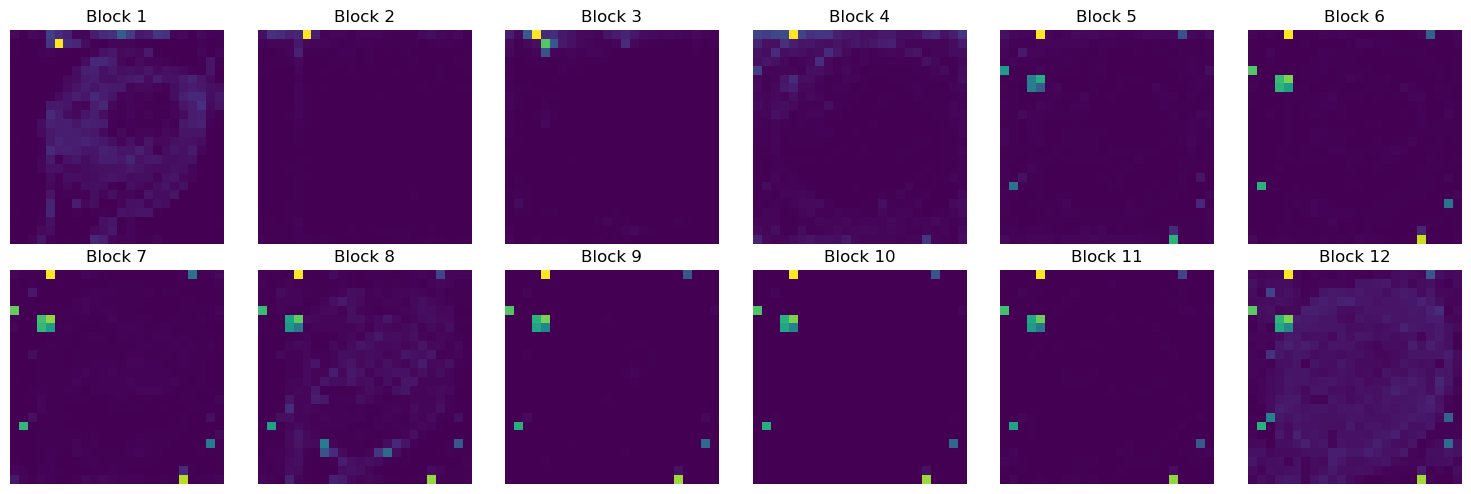

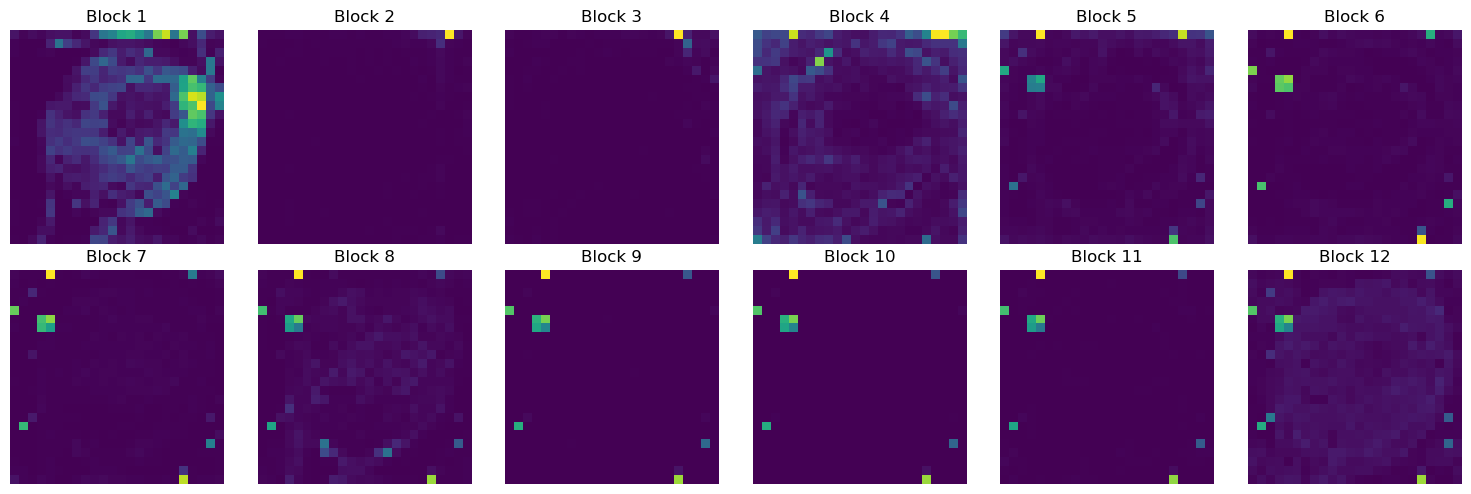

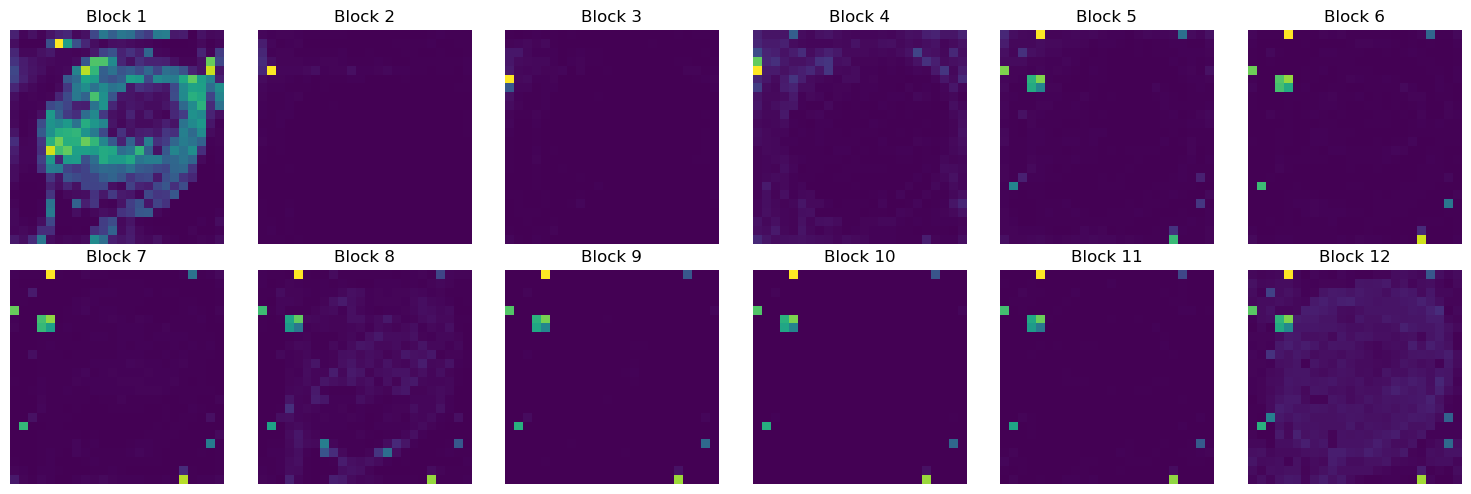

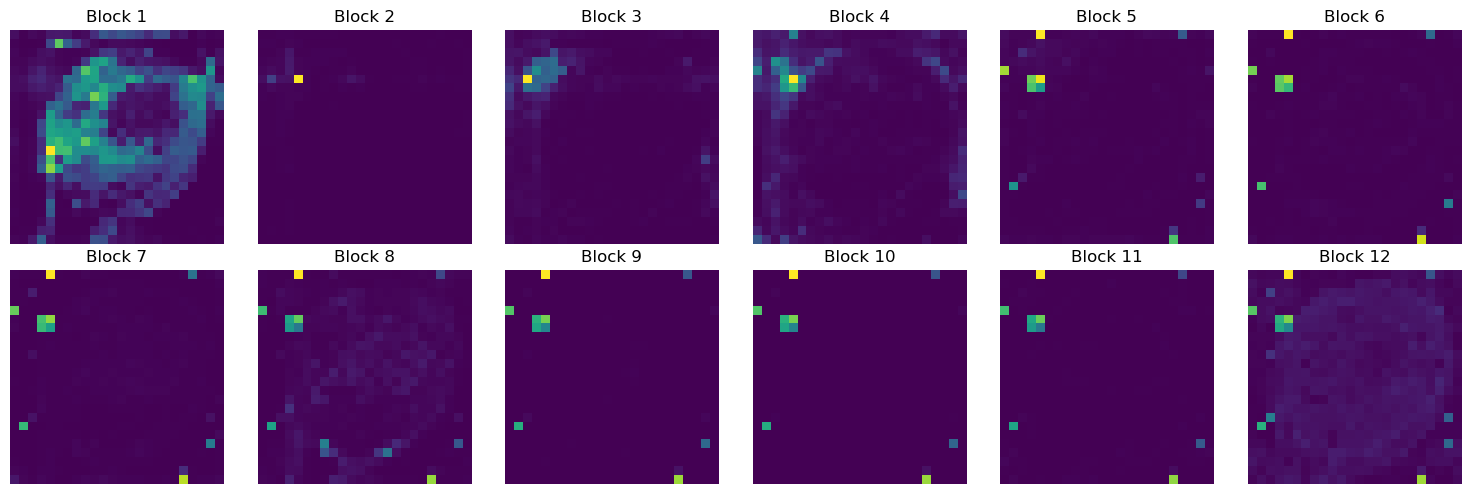

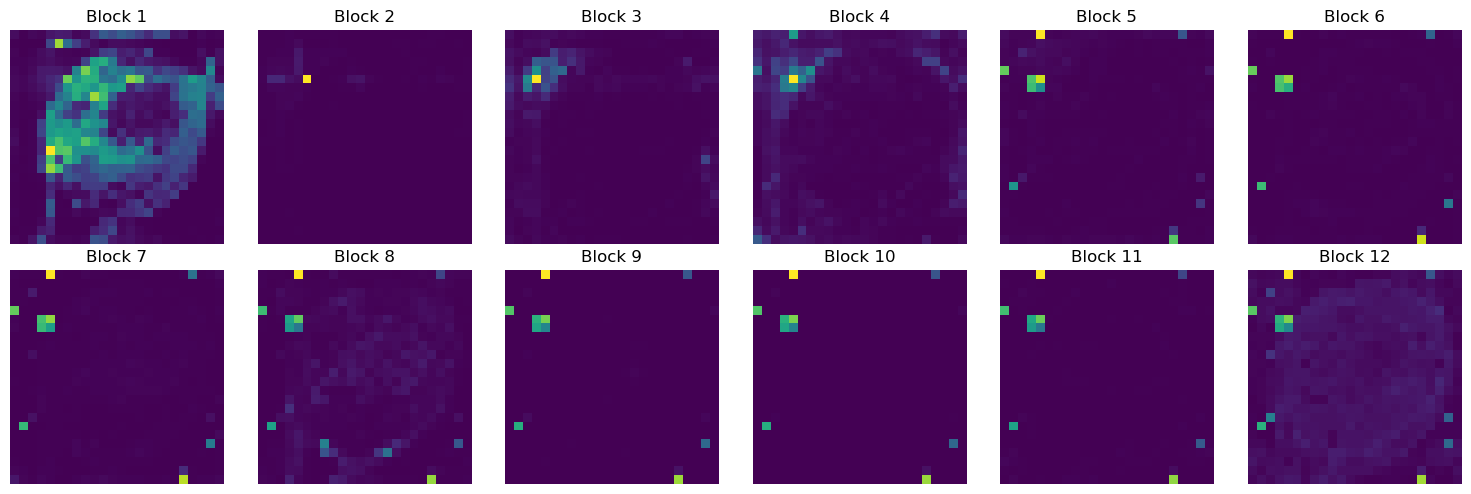

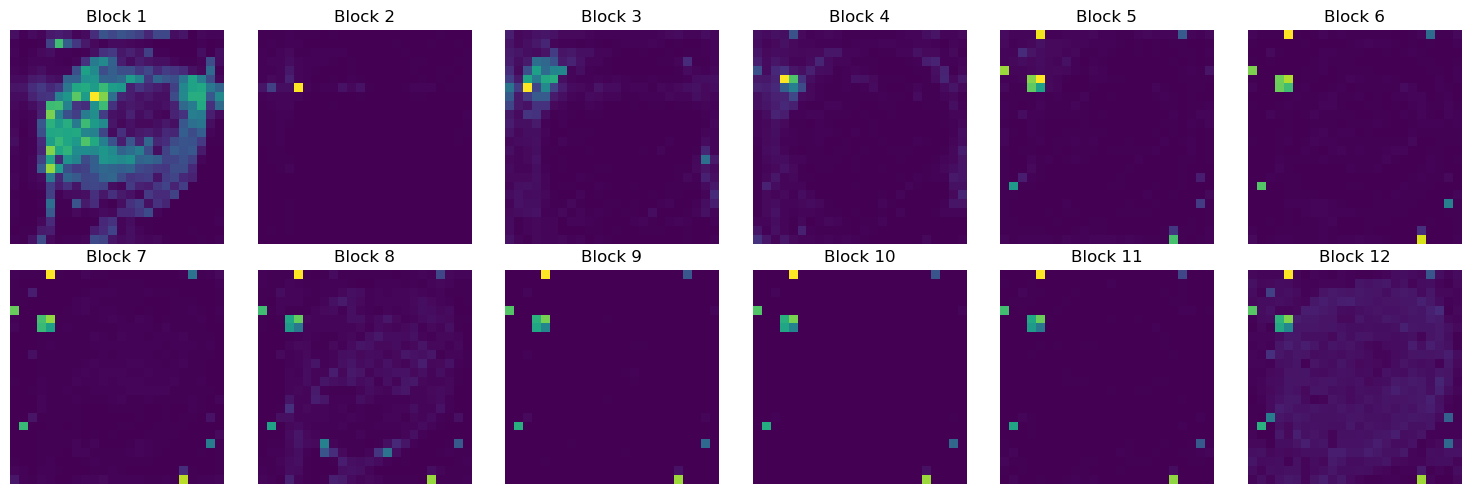

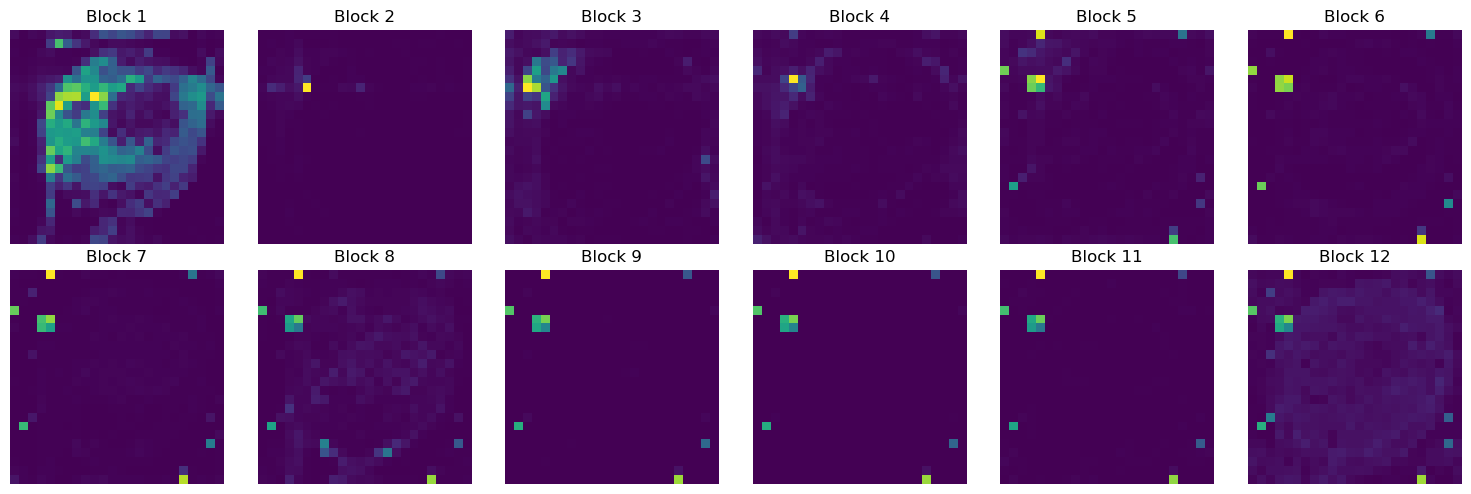

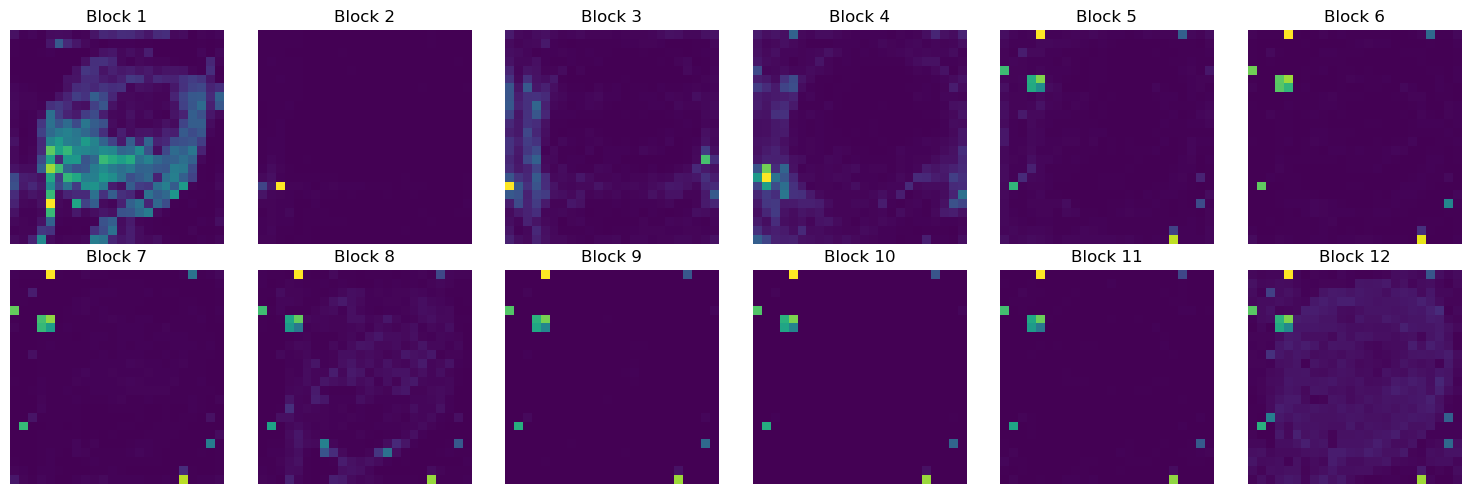

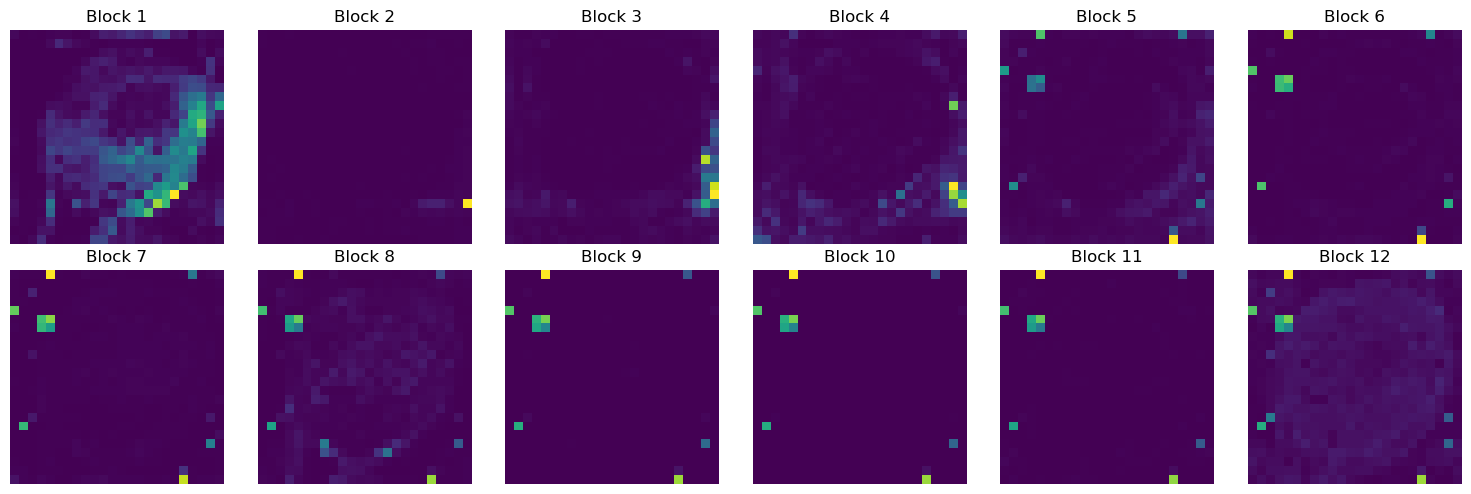

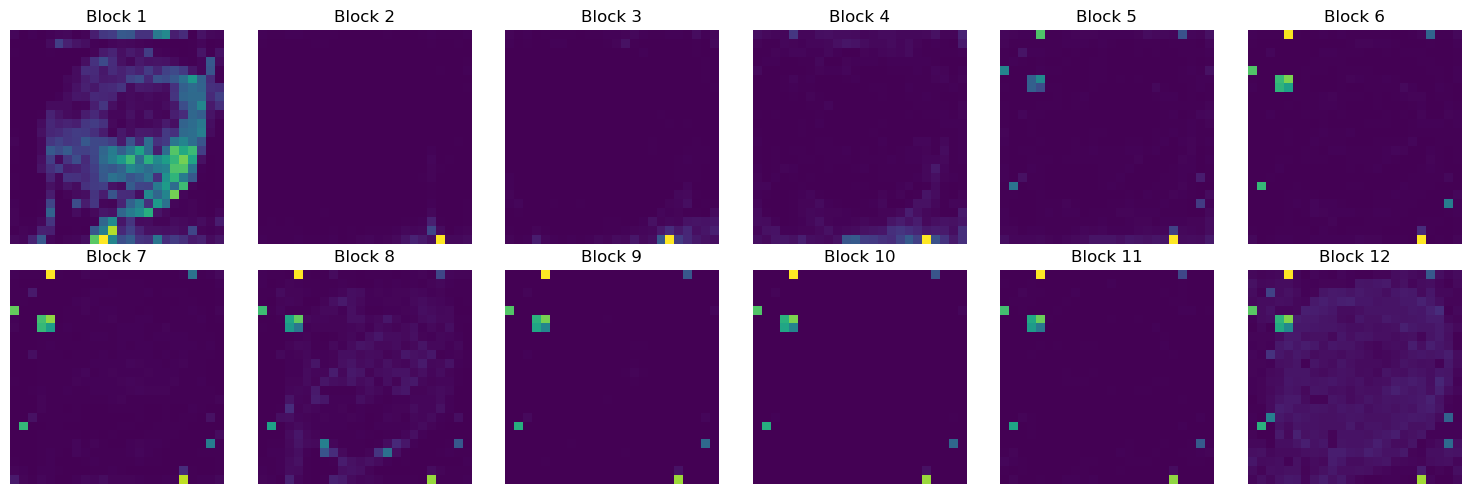

In [23]:
for x in intersection:
    show_progression(chosen_one, token = x)

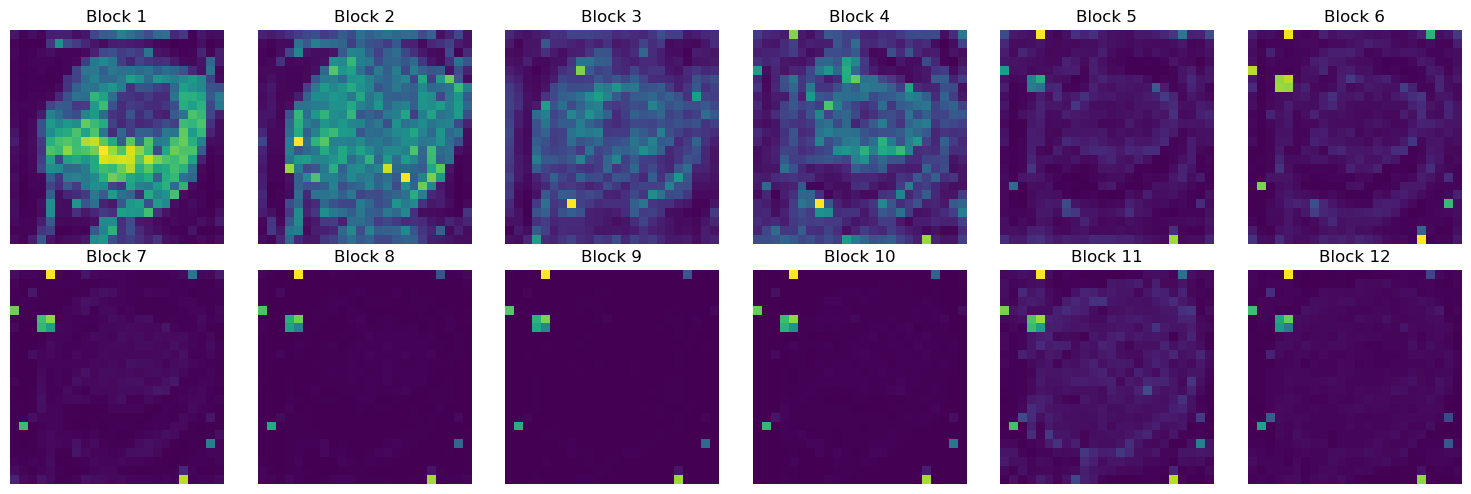

In [24]:
show_progression(chosen_one, token = 'cls')

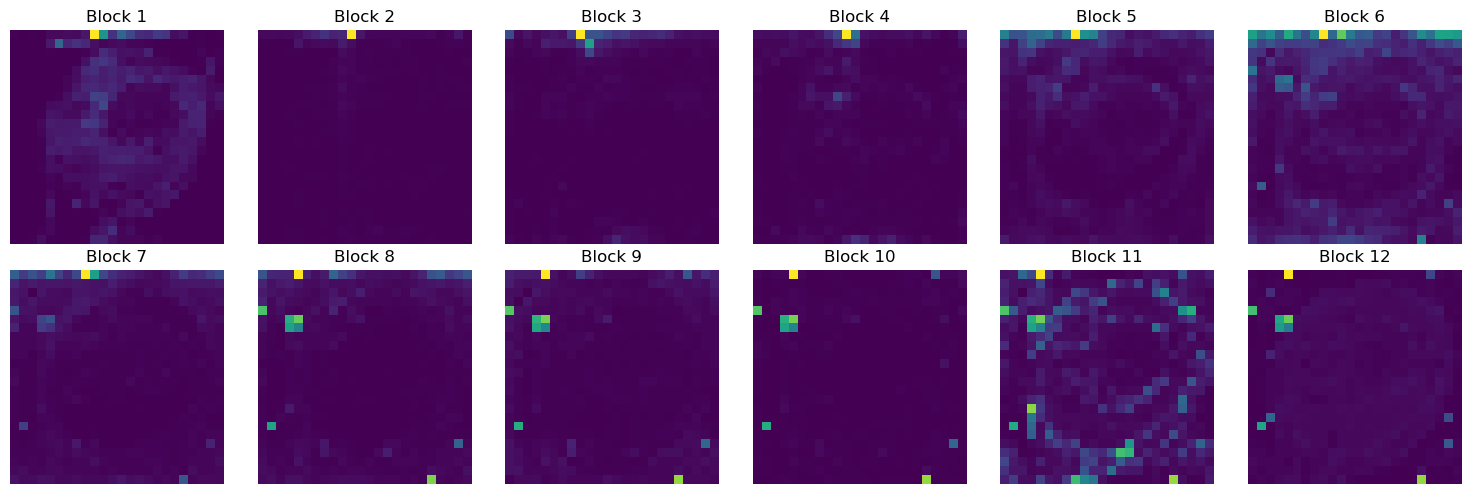

In [25]:
show_progression(chosen_one, token = 9)

### training with cifar

In [26]:
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torchvision

# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 1500
test_subset_size = 400
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 16
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading DINOv2 model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = chosen_one
model.to(device)
model.eval()
print("DINOv2 model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 1500 training images, 400 testing images...
Subsets and DataLoaders ready.
Loading DINOv2 model...
DINOv2 model loaded and ready.


In [27]:
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    with torch.no_grad():
        model(images)
    a = model.block_output['final']
    break

In [28]:
a.shape

torch.Size([16, 577, 384])

In [29]:
from sklearn.model_selection import train_test_split

# Extract Patch Embeddings and Norms

high_norm_tokens = []
normal_tokens = []
labels_high = []  
labels_normal = [] 

print("Extracting patch embeddings...")
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)

    with torch.no_grad():
        model(images)
        #features = model.block_output['final']
        features = model.block_output['block11']
        
        patch_features = features[:, 1:, :]  
        norms = torch.norm(patch_features, dim=-1).cpu().numpy()

        for i in range(images.size(0)):  
            single_patch_features = patch_features[i]
            single_norms = norms[i]

            single_norms_tensor = torch.tensor(single_norms)
            top_tokens = torch.argsort(single_norms_tensor, descending=True)[:10].numpy()
            high_indices = np.where(single_norms > single_norms[top_tokens[-1]])[0]
            normal_indices = np.where(single_norms <= single_norms[top_tokens[-1]])[0]

            if high_indices.size > 0:
                high_norm_token = single_patch_features[high_indices[np.random.randint(len(high_indices))], :].cpu().numpy()
                high_norm_tokens.append(high_norm_token)
                labels_high.append(targets[i].item())

            if normal_indices.size > 0:
                normal_token = single_patch_features[normal_indices[np.random.randint(len(normal_indices))], :].cpu().numpy()
                normal_tokens.append(normal_token)
                labels_normal.append(targets[i].item())
    
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")

print("Patch embedding extraction complete.")

print("Preparing datasets for Logistic Regression...")
X_high = np.array(high_norm_tokens)
X_normal = np.array(normal_tokens)
y_high = np.array(labels_high)
y_normal = np.array(labels_normal)

print(len(X_high), len(X_normal))
print(len(y_high), len(y_normal))

print("Splitting data into training and testing sets...")
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.2, random_state=42)
X_normal_train, X_normal_test, y_normal_train, y_normal_test = train_test_split(X_normal, y_normal, test_size=0.2, random_state=42)

Extracting patch embeddings...
Processed batch 1/94
Processed batch 2/94
Processed batch 3/94
Processed batch 4/94
Processed batch 5/94
Processed batch 6/94
Processed batch 7/94
Processed batch 8/94
Processed batch 9/94
Processed batch 10/94
Processed batch 11/94
Processed batch 12/94
Processed batch 13/94
Processed batch 14/94
Processed batch 15/94
Processed batch 16/94
Processed batch 17/94
Processed batch 18/94
Processed batch 19/94
Processed batch 20/94
Processed batch 21/94
Processed batch 22/94
Processed batch 23/94
Processed batch 24/94
Processed batch 25/94
Processed batch 26/94
Processed batch 27/94
Processed batch 28/94
Processed batch 29/94
Processed batch 30/94
Processed batch 31/94
Processed batch 32/94
Processed batch 33/94
Processed batch 34/94
Processed batch 35/94
Processed batch 36/94
Processed batch 37/94
Processed batch 38/94
Processed batch 39/94
Processed batch 40/94
Processed batch 41/94
Processed batch 42/94
Processed batch 43/94
Processed batch 44/94
Processed 

In [30]:
# Train Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print("Training Logistic Regression classifiers...")
clf_high = LogisticRegression(max_iter=1000).fit(X_high_train, y_high_train)
print("High-Norm Token classifier trained.")

clf_normal = LogisticRegression(max_iter=1000).fit(X_normal_train, y_normal_train)
print("Normal Token classifier trained.")

print("Evaluating classifiers...")
high_acc = accuracy_score(y_high_test, clf_high.predict(X_high_test))
normal_acc = accuracy_score(y_normal_test, clf_normal.predict(X_normal_test))

print(f"High-Norm Token Accuracy: {high_acc:.4f}")
print(f"Normal Token Accuracy: {normal_acc:.4f}")

Training Logistic Regression classifiers...
High-Norm Token classifier trained.
Normal Token classifier trained.
Evaluating classifiers...
High-Norm Token Accuracy: 0.8467
Normal Token Accuracy: 0.7867


### cosine similarity

In [26]:
embedding = chosen_one.patch_embed(img).squeeze(0)
top_norm = top_norm_tokens(chosen_one)[:10]

In [27]:
all_tokens = dict()
for x in range(24*24):
    emb = embedding[x].detach()#.numpy()
    right = embedding[(x+1) % (24*24)]
    left = embedding[x-1]
    up = embedding[x-24]
    down = embedding[(x+24) % (24*24)]

    cos_sim = torch.nn.CosineSimilarity(dim=0)
    mean_sim = (cos_sim(emb, right) + cos_sim(emb, left) + cos_sim(emb, up) + cos_sim(emb, down))/4

    all_tokens[x] = mean_sim.detach().numpy()

In [28]:

top_norm_keys = set(top_norm.cpu().numpy())
top_norm_similarities = [all_tokens[key] for key in top_norm_keys]

not_top_norm_keys = set(all_tokens.keys()) - top_norm_keys
not_top_norm_similarities = [all_tokens[key] for key in not_top_norm_keys]


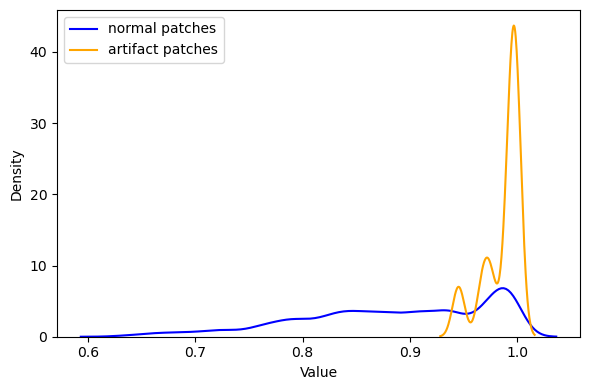

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

top_norm_similarities = [float(similarity) for similarity in top_norm_similarities]
not_top_norm_similarities = [float(similarity) for similarity in not_top_norm_similarities]

# Plot density
plt.figure(figsize=(6, 4))
sns.kdeplot(not_top_norm_similarities, label='normal patches', color='blue', bw_adjust=0.5)
sns.kdeplot(top_norm_similarities, label='artifact patches', color='orange', bw_adjust=0.5)

# Add labels and legend
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


### training position

In [44]:
from torch.utils.data import Subset, DataLoader
from torchvision import transforms
import torchvision

# logistic regression norm-normal 
print("Loading CIFAR-10 dataset...")
transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_subset_size = 1000
test_subset_size = 10
print(f"Creating subsets: {train_subset_size} training images, {test_subset_size} testing images...")
train_indices = torch.randperm(len(train_dataset))[:train_subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
print("Subsets and DataLoaders ready.")

print("Loading model...")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('mps')
model = chosen_one
model.to(device)
model.eval()
print("Model loaded and ready.")

Loading CIFAR-10 dataset...
Files already downloaded and verified
Files already downloaded and verified
Creating subsets: 1000 training images, 10 testing images...
Subsets and DataLoaders ready.
Loading model...
Model loaded and ready.


In [45]:
device = torch.device('mps')

In [46]:
# put all elements of the train loader in a single ndarray
print("Extracting patch embeddings...")
patch_embeddings = []
labels = []
for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    with torch.no_grad():
        chosen_one(images)
    patch_embeddings.append(chosen_one.block_output['block11'][:,1:,:].cpu().numpy())
    labels.append(targets.numpy())
    print(f"Processed batch {batch_idx + 1}/{len(train_loader)}")
patch_embeddings = np.concatenate(patch_embeddings, axis=0)
labels = np.concatenate(labels, axis=0)
print("Patch embeddings extracted.")


Extracting patch embeddings...


KeyboardInterrupt: 

In [41]:
patch_embeddings.shape

(100, 576, 384)

In [34]:
y = np.array(range(576))
y = np.tile(y, 100)
y.shape

(57600,)

In [35]:
patch_embeddings_new = patch_embeddings.reshape(-1, patch_embeddings.shape[-1])
patch_embeddings_new.shape

(57600, 384)

In [39]:
import torch.nn as nn

class ClassificationMLP(nn.Module):
    def __init__(self, input_dim=384, output_dim=576):
        super(ClassificationMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

# Example usage
model = ClassificationMLP()
print(model)

ClassificationMLP(
  (fc1): Linear(in_features=384, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=576, bias=True)
  (softmax): Softmax(dim=1)
)


In [38]:
import torch.nn as nn

class ClassificationMLP_small(nn.Module):
    def __init__(self, input_dim=384, output_dim=576):
        super(ClassificationMLP_small, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.softmax(x)
        return x

# Example usage
model = ClassificationMLP_small()
print(model)

ClassificationMLP_small(
  (fc1): Linear(in_features=384, out_features=576, bias=True)
  (softmax): Softmax(dim=1)
)


In [42]:
device

device(type='mps')

In [43]:
# train the model
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(patch_embeddings_new, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

# Create the model and optimizer
model = ClassificationMLP_small()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 1
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor), batch_size):
        # Get the current batch
        X_batch = X_train_tensor[i:i+batch_size].to(device)
        y_batch = y_train_tensor[i:i+batch_size].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Compute the loss
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    # Compute the accuracy
    with torch.no_grad():
        y_pred_train = model(X_train_tensor.to(device)).argmax(dim=1)
        train_acc = (y_pred_train == y_train_tensor.to(device)).float().mean()

        y_pred_test = model(X_test_tensor.to(device)).argmax(dim=1)
        test_acc = (y_pred_test == y_test_tensor.to(device)).float().mean()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device)).argmax(dim=1)
    acc = (y_pred == y_test_tensor.to(device)).float().mean()
    print(f"Test Accuracy: {acc:.4f}")



Epoch 1/1, Loss: 6.3591, Train Acc: 0.0017, Test Acc: 0.0018
Test Accuracy: 0.0018
